In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

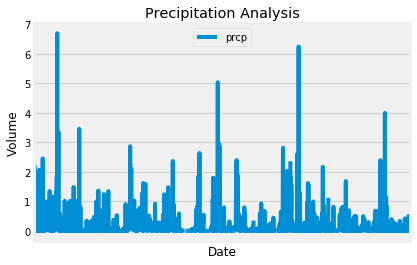

In [12]:
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > one_year_ago).order_by(Measurement.date).all()

prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])

prcp_df.set_index('date').head()

prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xticks([])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Precipitation Analysis")
plt.legend(loc='upper center')
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
Stations_analysis = Base.classes.station

list(Stations_analysis.__table__.columns)

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [15]:
# Design a query to show how many stations are available in this dataset?
stations_count = (session
                  .query(Stations_analysis.station)
                  .count())
stations_count

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Most_active_stations = (session
                   .query(Measurement.station, func.count(Measurement.date))
                   .order_by(func.count(Measurement.date).desc())
                   .group_by(Measurement.station)
                   .all())
Most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active= session.query(Measurement.station, func.count(Measurement.station)).\
  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
masq =session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
  filter(Measurement.station== most_active[0]).all()
print(f"The most active station was {masq[0][0]}. The lowest temperature recorded was {masq[0][1]}F,the highest temperature was {masq[0][2]}F, and the  average temperature was {masq[0][2]}F.")

The most active station was USC00519281. The lowest temperature recorded was 54.0F,the highest temperature was 85.0F, and the  average temperature was 85.0F.


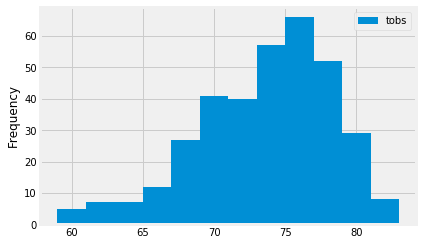

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#df_station = pd.read_sql("SELECT measurement.date, measurement.tobs FROM measurement WHERE measurement.date >= '2016-08-24' AND measurement.tobs > 0.0 AND measurement.station='USC00519281'",conn)
querystation = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-24').filter(Measurement.station=='USC00519281')
df_station = pd.DataFrame(querystation, columns=['tobs'])
df_station.plot.hist(bins=12,alpha=1)
#GROUP BY measurement.date ORDER BY measurement.date

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= one_year_ago).all()

trip_avg= calc_temps('2012-02-28', '2012-03-05')
trip_avg

[(53.0, 73.20669014084507, 86.0)]

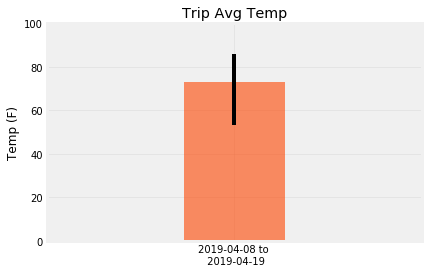

<Figure size 720x1440 with 0 Axes>

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip = '2019-04-08 to \n 2019-04-19'
trip_start_date = '2017-04-08'
trip_end_date = '2017-04-19'
trip_temps = calc_temps(trip_start_date, trip_end_date)
trip_temps
min_trip_temp = trip_avg[0][0]
avg_trip_temp = trip_avg[0][1]
max_trip_temp = trip_avg[0][2]
min_error = avg_trip_temp - min_trip_temp
max_error = max_trip_temp - avg_trip_temp
error_bars = np.array([[min_error], [max_error]])
plt.bar(trip, avg_trip_temp, yerr=error_bars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)
plt.figure(figsize=(10,20))
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Convert results to dataframe
start_date_dt = dt.datetime.strptime(trip_start_date, '%Y-%m-%d')
end_date_dt = dt.datetime.strptime(trip_end_date, '%Y-%m-%d')
session.query(Measurement.station,
             func.avg(Measurement.prcp)). \
           filter(Measurement.date.between(start_date_dt, end_date_dt)). \
           group_by(Measurement.station). \
           order_by(func.avg(Measurement.prcp).desc()).all()


[('USC00516128', 0.6709090909090909),
 ('USC00519281', 0.6345454545454544),
 ('USC00513117', 0.22545454545454546),
 ('USC00514830', 0.12285714285714286),
 ('USC00519523', 0.08099999999999999),
 ('USC00519397', 0.028181818181818186),
 ('USC00517948', 0.0)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
